In [1]:
# Goal of this notebook is to implement the dynamical model of Neggers et al. (2006).
# Figure 4 of Neggers et al. (2006) is reproduced, but the equilibrium values do not coincide with theirs.
# They coincides with those published by Youtong Zheng here https://github.com/youtongzheng/Neggers_2006.

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [2]:
# Define some meteorological functions from pycoare.
def qsat(t,p):
    """
    usage: es = qsat(t,p)
    Returns saturation vapor pressure es (mb) given t(C) and p(mb).
    After Buck, 1981: J.Appl.Meteor., 20, 1527-1532
    Returns ndarray float for any numeric object input.
    """
    from numpy import copy, asarray, exp

    t2 = copy(asarray(t, dtype=float))  # convert to ndarray float
    p2 = copy(asarray(p, dtype=float))
    es = 6.1121 * exp(17.502 * t2 / (240.97 + t2))
    es = es * (1.0007 + p2 * 3.46e-6)
    return es

def qsea(sst,p):
    """
    usage: qs = qsea(sst,p)
    Returns saturation specific humidity (g/kg) at sea surface
    given sst(C) and p(mb) input of any numeric type.
    Returns ndarray float for any numeric object input.
    """
    ex = qsat(sst,p) # returns ex as ndarray float
    es = ex#0.98 * ex # This is the correction for the effect of salinity, which we remove now
    qs = 622*es/(p-0.378*es) # saturation specific humidity
    return qs

In [3]:
def neggers_et_al_2006(t,y,V,SST,D,q_free,th_free,ps):
    """
    Subscript s denotes surface values, b stands for buoyancy, which is associated with the virtual potential
    temperature (theta_v), th indicates the liquid water potential temperature (theta_l) and q the total specific
    humidity (q_t).
    """
    # Define some constants.
    delta_z = 100.0 # [m]
    Cqs = 0.0012 # [1], surface exchange coefficient for q
    Cths = 0.0012 # [1], surface exchange coefficient for theta
    Cqc = 0.1 # [1], cloud level exchange coefficient for q
    Cthc = 0.03 # [1], cloud level exchange coefficient for theta
    Le = 2.5e6 # [J/kg], latent heat of vaporization 
    cpd  = 1004.67 # [J/K/kg], dry air specific heat at constant pressure
    Rd = 287.1 # [J/K/kg], dry air gas constant
    # air density is supposed to be constant and equal to 1...
    beta = 0.36
    gamma = 1.55
    g = 9.81 # [m/s2], acceleration due to gravity
    
    ### Define some forcing variables for the BOMEX example -> this will be given as input parameters.
    #V = 8.75 # [m/s], large scale horizontal wind
    #SST = 300.4 # [K], sea surface temperature
    #D = 4.3e-6 # [1/s], large scale divergence
    #q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
    #th_free = 308 # [K], free tropospheric liquid virtual potential temperature
    F_advq = -1.2e-3/86400 # [kg/kg/s]
    F_advth = 0.0/86400 # [K/s]
    F_rad = -2.0/86400 # [K/s]
    #ps = 1015 # [hPa], surface pressure
    ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
    q_s = qsea(SST-273.15,ps)*1e-3 # [kg/kg], surface total specific humidity (saturation value)
    th_s = SST*(ref_p/ps)**(Rd/cpd) # [K], surface liquid water potential temperature, assuming no liquid water at the surface
    
    ### Define some diagnostic variables.
    # Entrainment.
    q_flux_s = V*Cqs*(q_s-y[1]) # total specific humidity flux at the surface
    th_flux_s = V*Cths*(th_s-y[2]) # liquid water potential temperature flux at the surface
    thv_flux_s = (1+0.61*q_s)*th_flux_s + 0.61*th_s*q_flux_s # surface virtual potential temp flux
    delta_q = Cqc*(q_free-y[1])
    delta_th = Cthc*(th_free-y[2])
    delta_thv = delta_th + 0.61*(y[1]*delta_th + y[2]*delta_q + delta_q*delta_th)
    E = 0.2*thv_flux_s/delta_thv
    # Mass flux.
    thv0 = y[2]*(1+0.61*y[1]) # [K], ABL virtual potential temperature
    b_flux_s = g*thv_flux_s/thv0 # surface buoyancy flux
    w_star = (y[0]*b_flux_s)**(1/3) # m/s, Deardorff convective velocity scale. 5th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(ps/ref_p)**(Rd/cpd)*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 4th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 3rd try
#    w_star = (g*y[0]*thv_flux_s/y[2])**(1/3) # m/s, Deardorff convective velocity scale. 2nd try
#    w_star = (g*y[0]*thv_flux_s/th_s)**(1/3) # m/s, Deardorff convective velocity scale. 1st try
    
    T0 = y[2]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
    T_h = T0-g/cpd*y[0] # [K], air temperature at h following a dry adiabat.
    p_h = ps*100*(1-g*y[0]/(T0*cpd))**(cpd/Rd) # [Pa], air pressure at h with p=rho*R*T; dp/dz=-rho*g; dtheta/dz=0 
    e_sat_h = qsat(T_h-273.15,p_h/100)*100 # [Pa], saturation vapor pressure at h.
    q_sat = 0.622*e_sat_h/(p_h-0.378*e_sat_h) # [kg/kg], saturation specific humidity at h.
   
    sigma_q = np.sqrt(-q_flux_s*delta_q*y[0]/(w_star*delta_z))
    area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)
    M = area_c*w_star
    
    ### Define the equations to be solved.
    dh_dt = E - D*y[0] - M 
    dq_dt = (q_flux_s + E*delta_q)/y[0] + F_advq
    dth_dt = (th_flux_s + E*delta_th)/y[0] + F_advth + F_rad
    
    #print(area_c)
    #print((y[1]-q_sat)*1e3)
    #print(sigma_q*1e3)
    #print(w_star)
    #print((y[1]-q_sat)/sigma_q)
    area_c_ext.append(area_c)
    w_star_ext.append(w_star)
    M_ext.append(M)
    E_ext.append(E)
    sigma_q_ext.append(sigma_q)
    LHF_ext.append(q_flux_s*Le)
    
    return dh_dt, dq_dt, dth_dt

In [6]:
# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2]

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0
area_c_ext = []
w_star_ext = []
M_ext = []
E_ext = []
sigma_q_ext = []
LHF_ext = []
sol = solve_ivp(neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps))#, t_eval=t_eval)

<ipython-input-3-9fcbf52a3e7b>:60: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


equilibrium h = 557.8276050713392 m
equilibrium q = 16.037547636702545 g/kg
equilibrium th = 299.1694613143642 K
equilibrium a$_c$ = 7.996415070198065%
equilibrium w$\star$ = 0.6018309511538078 m/s


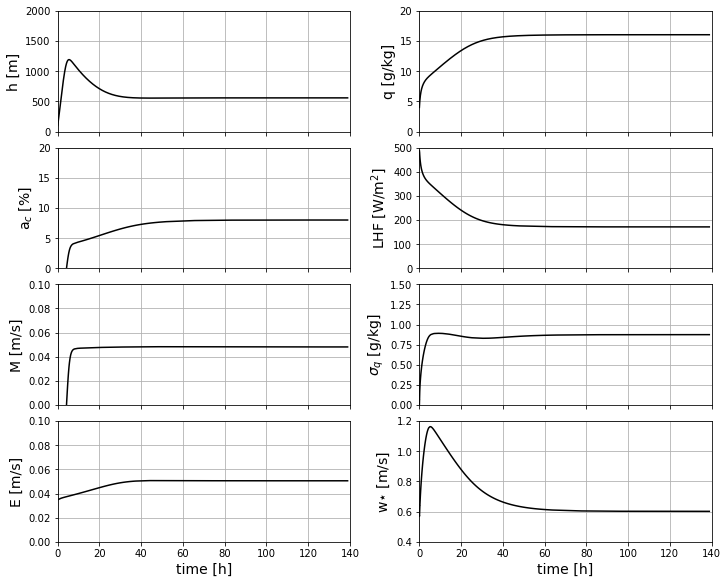

In [7]:
# Plots for a single run.
h = sol.y[0]
q = sol.y[1]
th = sol.y[2]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final = np.max(sol.t)
dt = t_final/3600/len(E_ext) # [h]
time_ext = np.arange(len(E_ext))*dt

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(area_c_ext[-1]*100)+'%')
print('equilibrium w$\star$ = '+str(w_star_ext[-1])+' m/s')

fig, ax = plt.subplots(4,2,figsize=(10,8),sharex=True,constrained_layout=True)

ax[0,0].plot(sol.t/3600,h,'k')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()

ax[0,1].plot(sol.t/3600,q*1e3,'k')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(sol.t/3600,sol.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

ax[1,0].plot(time_ext,np.array(area_c_ext)*100,'k')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext,np.array(LHF_ext),'k')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext,np.array(M_ext),'k')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext,np.array(sigma_q_ext)*1e3,'k')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext,np.array(E_ext),'k')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext,np.array(w_star_ext),'k')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[3,0].set_xlabel('time [h]',fontsize=14)
ax[3,1].set_xlabel('time [h]',fontsize=14)
ax[3,0].set_xlim(0,140)
ax[3,1].set_xlim(0,140)

# Define the variables with constant V(_mag), CV
h_CV = h
q_CV = q
area_c_ext_CV = area_c_ext
LHF_ext_CV = LHF_ext
M_ext_CV = M_ext
sigma_q_ext_CV = sigma_q_ext
E_ext_CV = E_ext
w_star_ext_CV = w_star_ext

In [52]:
# Now test the dependence of the solution to some external parameters.

# Initial conditions: y0 = [h(0),q(0),th(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2]

# Input parameters
V = 8.75 # [m/s], large scale horizontal wind
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

# Neggers et al. (2006) forcing and equilibrium values.
V_N06 = 8.75 # [m/s], large scale horizontal wind
SST_N06 = 300.4 # [K], sea surface temperature
D_N06 = 4.3e-6 # [1/s], large scale divergence
q_free_N06 = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free_N06 = 308 # [K], free tropospheric liquid virtual potential temperature
ps_N06 = 1015 # [hPa], surface pressure
q_s_N06 = qsea(SST_N06-273.15,ps_N06)*1e-3

h_N06 = 692 # m/s
q_N06 = 15 # g/kg
#th_N06 = 
a_c_N06 = 4.3 # %
w_star_N06 = 0.75 # m/s
M_N06 = 0.032 # m/s
h_N06 = 692 # m/s
q_N06 = 15 # g/kg
#th_N06 = 
a_c_N06 = 4.3 # %
w_star_N06 = 0.75 # m/s
M_N06 = 0.032 # m/s

# Set a single parameter to change. Remember to change the name of the variable in the following for loop.
str_variable = 'V'; list_of_values = np.arange(5,15,1); str_units = 'm/s'; x_N06 = V_N06
#str_variable = 'SST'; list_of_values = np.arange(300,306,0.5); str_units = 'K'; x_N06 = SST_N06
#str_variable = 'D'; list_of_values = np.arange(2.5,6.5,0.25)*1e-6; str_units = '1/s'; x_N06 = D_N06
#str_variable = 'q_free'; list_of_values = np.arange(2.0e-3,4.0e-3,0.2e-3); str_units = 'kg/kg'; x_N06 = q_free_N06
#str_variable = 'th_free'; list_of_values = np.arange(302,312); str_units = 'K'; x_N06 = th_free_N06
#str_variable = 'ps'; list_of_values = np.arange(1000,1030,5); str_units = 'hPa'; x_N06 = ps_N06

#---------
h_eq = np.zeros((len(list_of_values),))
q_eq = h_eq.copy()
th_eq = h_eq.copy()
a_c_eq = h_eq.copy()
w_star_eq = h_eq.copy()
M_eq = h_eq.copy()

for jj,V in enumerate(list_of_values):
    ii=0
    area_c_ext = []
    w_star_ext = []
    M_ext = []
    sol = solve_ivp(neggers_et_al_2006, time, y0, dense_output=True, max_step=dt_max, args=(V,SST,D,q_free,th_free,ps))#, t_eval=t_eval)
    h_eq[jj] = sol.y[0][-1]
    q_eq[jj] = sol.y[1][-1]
    th_eq[jj] = sol.y[2][-1]
    a_c_eq[jj] = area_c_ext[-1]
    w_star_eq[jj] = w_star_ext[-1]
    M_eq[jj] = M_ext[-1]
    print(str(np.round(100*(jj+1)/len(list_of_values)))+' percent')
    print('---------------------------------------')

<ipython-input-25-f2b21580af1e>:61: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


10.0 percent
---------------------------------------
20.0 percent
---------------------------------------
30.0 percent
---------------------------------------
40.0 percent
---------------------------------------
50.0 percent
---------------------------------------
60.0 percent
---------------------------------------
70.0 percent
---------------------------------------
80.0 percent
---------------------------------------
90.0 percent
---------------------------------------
100.0 percent
---------------------------------------


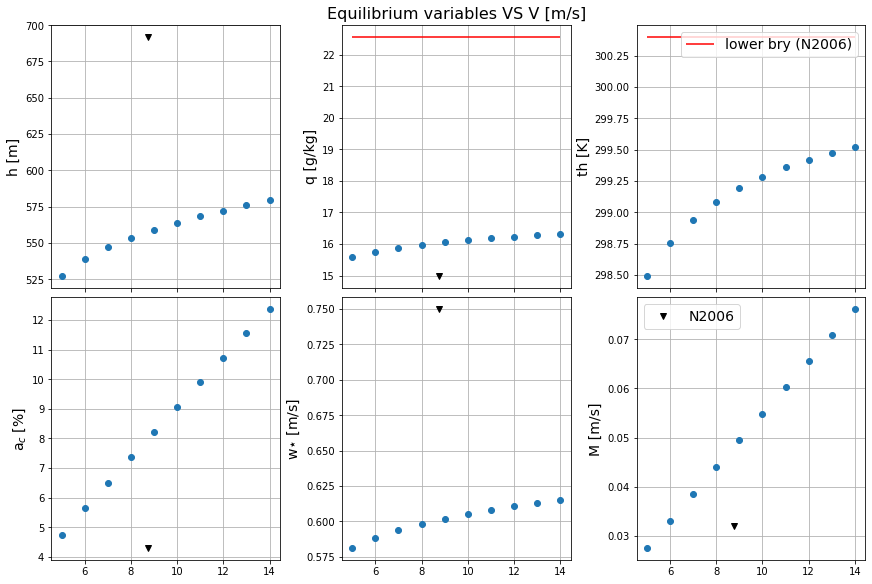

In [53]:
fig, ax = plt.subplots(2,3,figsize=(12,8),sharex=True,constrained_layout=True)

ax[0,0].plot(list_of_values,h_eq,'o')
ax[0,0].grid()
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].plot(x_N06,h_N06,'kv')

ax[0,1].plot(list_of_values,q_eq*1e3,'o')
ax[0,1].grid()
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].hlines(q_s_N06*1e3,list_of_values[0],list_of_values[-1],'r')
ax[0,1].plot(x_N06,q_N06,'kv')

ax[0,2].plot(list_of_values,th_eq,'o')
ax[0,2].grid()
ax[0,2].set_ylabel('th [K]',fontsize=14)
ax[0,2].hlines(SST_N06,list_of_values[0],list_of_values[-1],'r',label='lower bry (N2006)')
ax[0,2].legend(fontsize=14)

ax[1,0].plot(list_of_values,a_c_eq*100,'o')
ax[1,0].grid()
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].plot(x_N06,a_c_N06,'kv')

ax[1,1].plot(list_of_values,w_star_eq,'o')
ax[1,1].grid()
ax[1,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[1,1].plot(x_N06,w_star_N06,'kv')

ax[1,2].plot(list_of_values,M_eq,'o')
ax[1,2].grid()
ax[1,2].set_ylabel('M [m/s]',fontsize=14)
ax[1,2].plot(x_N06,M_N06,'kv',label='N2006')
ax[1,2].legend(fontsize=14)

ax[0,1].set_title('Equilibrium variables VS '+str_variable+' ['+str_units+']',fontsize=16)

figure_name = 'equilibrium_variables_dependence_on_' + str_variable + '.png'
plt.savefig(figure_name,bbox_inches='tight')

In [70]:
a = 6/np.sqrt(1+np.tan(22.5*np.pi/180)**2)
print(a)

5.54327719506772


In [73]:
b = np.tan(22.5*np.pi/180)*a
print(b)

2.296100594190538


In [74]:
np.sqrt(5.5**2+2.3**2)

5.961543424315552

In [91]:
def neggers_et_al_2006_stevens_et_al_2002(t,y,SST,D,q_free,th_free,ps,f,U_free,V_free,we):
    """
    Subscript s denotes surface values, b stands for buoyancy, which is associated with the virtual potential
    temperature (theta_v), th indicates the liquid water potential temperature (theta_l) and q the total specific
    humidity (q_t).
    A bulk model of the wind speed is added starting from the Stevens et al., JCli (2002) paper
    "Entrainment, Rayleigh friction, and boundary layer winds over the tropical Pacific"
    y[3] is U, the zonal bulk wind component
    y[4] is V, the meridional bulk wind component
    V_mag is the magnitude of the bulk wind = np.sqrt(y[3]**2+y[4]**2)
    """
    # Define some constants.
    delta_z = 100.0 # [m]
    Cqs = 0.0012 # [1], surface exchange coefficient for q
    Cths = 0.0012 # [1], surface exchange coefficient for theta
    Cqc = 0.1 # [1], cloud level exchange coefficient for q
    Cthc = 0.03 # [1], cloud level exchange coefficient for theta
    Le = 2.5e6 # [J/kg], latent heat of vaporization 
    cpd  = 1004.67 # [J/K/kg], dry air specific heat at constant pressure
    Rd = 287.1 # [J/K/kg], dry air gas constant
    # air density is supposed to be constant and equal to 1...
    beta = 0.36
    gamma = 1.55
    g = 9.81 # [m/s2], acceleration due to gravity
    CD = 1/900. # drag coefficient.
    
    ### Define some forcing variables for the BOMEX example -> this will be given as input parameters.
    #V = 8.75 # [m/s], large scale horizontal wind
    #SST = 300.4 # [K], sea surface temperature
    #D = 4.3e-6 # [1/s], large scale divergence
    #q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
    #th_free = 308 # [K], free tropospheric liquid virtual potential temperature
    F_advq = -1.2e-3/86400 # [kg/kg/s]
    F_advth = 0.0/86400 # [K/s]
    F_rad = -2.0/86400 # [K/s]
    #ps = 1015 # [hPa], surface pressure
    ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
    q_s = qsea(SST-273.15,ps)*1e-3 # [kg/kg], surface total specific humidity (saturation value)
    th_s = SST*(ref_p/ps)**(Rd/cpd) # [K], surface liquid water potential temperature, assuming no liquid water at the surface
    
    ### Define some diagnostic variables.
    # Entrainment.
    V_mag = np.sqrt(y[3]**2+y[4]**2) # [m/s], bulk wind speed.
    q_flux_s = V_mag*Cqs*(q_s-y[1]) # total specific humidity flux at the surface
    th_flux_s = V_mag*Cths*(th_s-y[2]) # liquid water potential temperature flux at the surface
    thv_flux_s = (1+0.61*q_s)*th_flux_s + 0.61*th_s*q_flux_s # surface virtual potential temp flux, <w'theta_v'>    # Entrainment.
    delta_q = Cqc*(q_free-y[1])
    delta_th = Cthc*(th_free-y[2])
    delta_thv = delta_th + 0.61*(y[1]*delta_th + y[2]*delta_q + delta_q*delta_th)
    E = 0.2*thv_flux_s/delta_thv
    # Mass flux.
    thv0 = y[2]*(1+0.61*y[1]) # [K], ABL virtual potential temperature
    b_flux_s = g*thv_flux_s/thv0 # surface buoyancy flux
    w_star = (y[0]*b_flux_s)**(1/3) # m/s, Deardorff convective velocity scale. 5th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(ps/ref_p)**(Rd/cpd)*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 4th try
#    w_star = (g*y[0]*thv_flux_s/(y[2]*(1+0.61*y[1])))**(1/3) # m/s, Deardorff convective velocity scale. 3rd try
#    w_star = (g*y[0]*thv_flux_s/y[2])**(1/3) # m/s, Deardorff convective velocity scale. 2nd try
#    w_star = (g*y[0]*thv_flux_s/th_s)**(1/3) # m/s, Deardorff convective velocity scale. 1st try
    
    T0 = y[2]*(ps/ref_p)**(Rd/cpd) # [K], air temperature at the surface, from the ABL theta value.
    T_h = T0-g/cpd*y[0] # [K], air temperature at h following a dry adiabat.
    p_h = ps*100*(1-g*y[0]/(T0*cpd))**(cpd/Rd) # [Pa], air pressure at h with p=rho*R*T; dp/dz=-rho*g; dtheta/dz=0 
    e_sat_h = qsat(T_h-273.15,p_h/100)*100 # [Pa], saturation vapor pressure at h.
    q_sat = 0.622*e_sat_h/(p_h-0.378*e_sat_h) # [kg/kg], saturation specific humidity at h.
   
    sigma_q = np.sqrt(-q_flux_s*delta_q*y[0]/(w_star*delta_z))
    area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)
    M = area_c*w_star
    
    ### Define the equations to be solved.
    dh_dt = E - D*y[0] - M 
    dq_dt = (q_flux_s + E*delta_q)/y[0] + F_advq
    dth_dt = (th_flux_s + E*delta_th)/y[0] + F_advth + F_rad
    dU_dt = f*(y[4]-V_free)-y[3]*(CD*V_mag+we)/y[0]+U_free*we/y[0]
    dV_dt = -f*(y[3]-U_free)-y[4]*(CD*V_mag+we)/y[0]+V_free*we/y[0]
    
    #print(area_c)
    #print((y[1]-q_sat)*1e3)
    #print(sigma_q*1e3)
    #print(w_star)
    #print((y[1]-q_sat)/sigma_q)
    area_c_ext.append(area_c)
    w_star_ext.append(w_star)
    M_ext.append(M)
    E_ext.append(E)
    sigma_q_ext.append(sigma_q)
    LHF_ext.append(q_flux_s*Le)
    
    return dh_dt, dq_dt, dth_dt, dU_dt, dV_dt

In [96]:
Omega = 2*np.pi/86400 # [rad/s] Earth rotation.
latitude0 = 10 # degree N
f = Omega * np.sin(latitude0*np.pi/180)
U_free = -5.5 # [m/s], free zonal wind (above the ABL).
V_free = -2.3 # [m/s], free meridional wind (above the ABL).
we = 0.005 # [m/s], entrainment velocity for the horizontal velocity.

# Initial conditions: y0 = [h(0),q(0),th(0),U(0),V(0)]
q_free = 4.0e-3 # kg/kg free tropospheric total mixing ratio
cpd  = 1004.67 # J/K/kg, dry air specific heat at constant pressure
Rd = 287.1 # J/K/kg, dry air gas constant
SST = 300.4 # K
ps = 1015 # [hPa], surface pressure
ref_p = 1000 # [hPa], reference pressure for the potential temperature: is this the surface pressure????
th_s = SST*(ref_p/ps)**(Rd/cpd) # surface liquid water potential temperature, assuming no liquid water at the surface
q_s = qsea(SST-273.15,ps)*1e-3

y0 = [100,q_free,th_s-2,U_free,V_free]

# Input parameters
#V = 8.75 # [m/s], large scale horizontal wind -> no longer needed!
SST = 300.4 # [K], sea surface temperature
D = 4.3e-6 # [1/s], large scale divergence
q_free = 4.0e-3 # [kg/kg] free tropospheric total mixing ratio
th_free = 308 # [K], free tropospheric liquid virtual potential temperature
ps = 1015 # [hPa], surface pressure

max_t = 5e5
dt_max = 60
time = [0, max_t]
#t_eval = np.arange(0,max_t,dt_max)

ii=0
area_c_ext = []
w_star_ext = []
M_ext = []
E_ext = []
sigma_q_ext = []
LHF_ext = []
sol = solve_ivp(neggers_et_al_2006_stevens_et_al_2002, time, y0, dense_output=True, max_step=dt_max, args=(SST,D,q_free,th_free,ps,f,U_free,V_free,we))#, t_eval=t_eval)

<ipython-input-91-836f191c3072>:64: RuntimeWarning: divide by zero encountered in double_scalars
  area_c = 0.5 + beta*np.arctan(gamma*(y[1]-q_sat)/sigma_q)


equilibrium h = 515.3762578188823 m
equilibrium q = 15.394204083502613 g/kg
equilibrium th = 298.20273700270735 K
equilibrium a$_c$ = 4.026508805045753%
equilibrium w$\star$ = 0.5738889871859784 m/s


(0.0, 140.0)

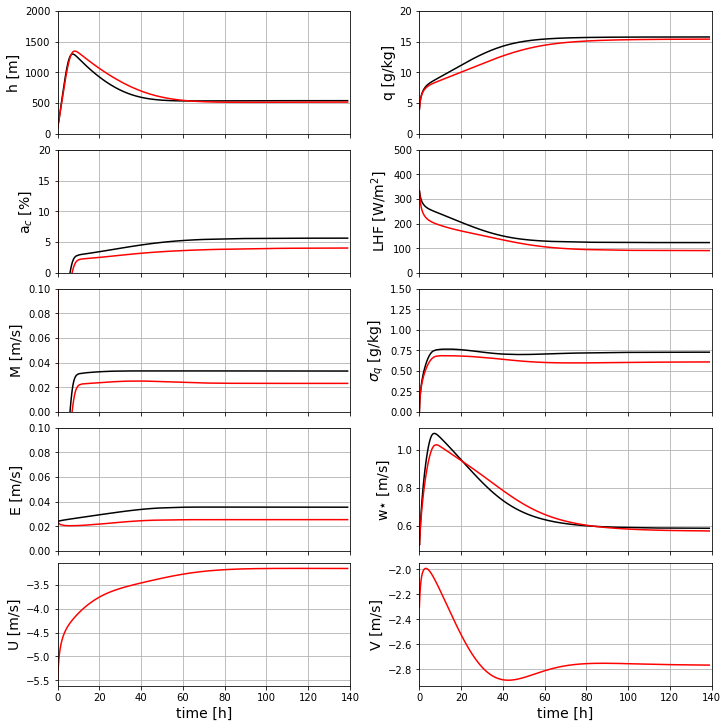

In [97]:
# Plots for a single run.
h = sol.y[0]
q = sol.y[1]
th = sol.y[2]
U = sol.y[3]
V = sol.y[4]

# Define a time axis for the variables that are not retrieved as standard output of the models.
t_final = np.max(sol.t)
dt = t_final/3600/len(E_ext) # [h]
time_ext = np.arange(len(E_ext))*dt

print('equilibrium h = '+str(h[-1])+' m')
print('equilibrium q = '+str(q[-1]*1e3)+' g/kg')
print('equilibrium th = ' +str(th[-1])+' K')
print('equilibrium a$_c$ = '+str(area_c_ext[-1]*100)+'%')
print('equilibrium w$\star$ = '+str(w_star_ext[-1])+' m/s')

fig, ax = plt.subplots(5,2,figsize=(10,10),sharex=True,constrained_layout=True)

ax[0,0].plot(sol.t/3600,h_CV,'k')
ax[0,0].plot(sol.t/3600,h,'r')
ax[0,0].set_ylabel('h [m]',fontsize=14)
ax[0,0].set_ylim(0,2e3)
ax[0,0].grid()

ax[0,1].plot(sol.t/3600,q_CV*1e3,'k')
ax[0,1].plot(sol.t/3600,q*1e3,'r')
ax[0,1].set_ylabel('q [g/kg]',fontsize=14)
ax[0,1].set_ylim(0,20)
ax[0,1].grid()

#plt.plot(sol.t/3600,sol.y[2],'.')
#plt.ylabel('th [K]',fontsize=14)
#plt.xlabel('time [h]',fontsize=14)
#plt.grid()
#plt.show()

ax[1,0].plot(time_ext,np.array(area_c_ext_CV)*100,'k')
ax[1,0].plot(time_ext,np.array(area_c_ext)*100,'r')
ax[1,0].set_ylabel('a$_c$ [%]',fontsize=14)
ax[1,0].set_ylim(0,20)
ax[1,0].grid()

ax[1,1].plot(time_ext,np.array(LHF_ext_CV),'k')
ax[1,1].plot(time_ext,np.array(LHF_ext),'r')
ax[1,1].set_ylabel('LHF [W/m$^2$]',fontsize=14)
ax[1,1].set_ylim(0,500)
ax[1,1].grid()

ax[2,0].plot(time_ext,np.array(M_ext_CV),'k')
ax[2,0].plot(time_ext,np.array(M_ext),'r')
ax[2,0].set_ylabel('M [m/s]',fontsize=14)
ax[2,0].set_ylim(0,0.10)
ax[2,0].grid()

ax[2,1].plot(time_ext,np.array(sigma_q_ext_CV)*1e3,'k')
ax[2,1].plot(time_ext,np.array(sigma_q_ext)*1e3,'r')
ax[2,1].set_ylabel('$\\sigma_q$ [g/kg]',fontsize=14)
ax[2,1].set_ylim(0,1.5)
ax[2,1].grid()

ax[3,0].plot(time_ext,np.array(E_ext_CV),'k')
ax[3,0].plot(time_ext,np.array(E_ext),'r')
ax[3,0].set_ylabel('E [m/s]',fontsize=14)
ax[3,0].set_ylim(0,0.10)
ax[3,0].grid()

ax[3,1].plot(time_ext,np.array(w_star_ext_CV),'k')
ax[3,1].plot(time_ext,np.array(w_star_ext),'r')
ax[3,1].set_ylabel('w$\star$ [m/s]',fontsize=14)
ax[3,1].set_ylim(0.4,1.2)
ax[3,1].grid()

ax[4,0].plot(sol.t/3600,U,'r')
ax[4,0].set_ylabel('U [m/s]',fontsize=14)
#ax[4,0].set_ylim(0,0.10)
ax[4,0].grid()

ax[4,1].plot(sol.t/3600,V,'r')
ax[4,1].set_ylabel('V [m/s]',fontsize=14)
#ax[4,1].set_ylim(0,0.10)
ax[4,1].grid()

ax[4,0].set_xlabel('time [h]',fontsize=14)
ax[4,1].set_xlabel('time [h]',fontsize=14)
ax[4,0].set_xlim(0,140)
ax[4,1].set_xlim(0,140)